In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

import sys
!{sys.executable} -m pip install xgboost
!pip3 install lightgbm
!pip install catboost

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#Define plot features of xgboost and lightgbm
from xgboost import plot_importance
from lightgbm import plot_importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

#Use to plot catboost
import matplotlib.pyplot as plt
%matplotlib inline

import time
import sys
import gc
import pickle


In [2]:
items = pd.read_csv('items.csv') # supplemental information about the items/products.
shops = pd.read_csv('shops.csv') # supplemental information about the shops.
item_cats = pd.read_csv('item_categories.csv') # supplemental information about the items categories.
sales = pd.read_csv('sales_train.csv') # the training set. Daily historical data from January 2013 to October 2015.
# set index to ID to avoid droping it later
test  = pd.read_csv('test.csv') #the test set. You need to forecast the sales for these shops and products for November 2015.

Data fields description

ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October

2015 is 33

item_name - name of item

shop_name - name of shop

item_category_name - name of item category

In [3]:
items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [4]:
shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [5]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


{'whiskers': [<matplotlib.lines.Line2D at 0x7f96557c6ee0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f96557de5e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f96557c6b80>],
 'medians': [<matplotlib.lines.Line2D at 0x7f96557deca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f96557defa0>],
 'means': []}

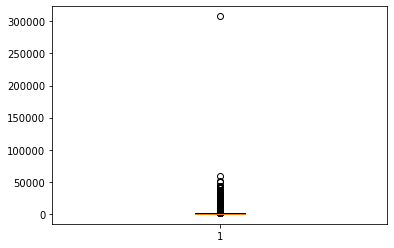

In [6]:
plt.boxplot(sales['item_price'])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f96558680d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9655868790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f965585cd30>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9655868e50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9655873190>],
 'means': []}

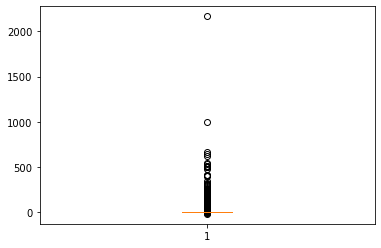

In [7]:
plt.boxplot(sales['item_cnt_day'])

In [8]:
train = sales[(sales.item_price < 80000) & (sales.item_price > 0)]
train = train[sales.item_cnt_day < 900]

<ipython-input-8-709a57518726>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train = train[sales.item_cnt_day < 900]


In [10]:
train[['item_price', 'item_cnt_day']].describe()

,item_price,item_cnt_day
count,2.935845e+06,2.935845e+06
mean,8.907495e+02,1.241562e+00
std,1.720491e+03,2.217636e+00
min,7.000000e-02,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,5.920000e+04,6.690000e+02


We find there are negative numbers, and the largest number is too large. It means we have to remove the outliers.

In [11]:
train[['item_price', 'item_cnt_day']].describe().to_csv('describe.csv')

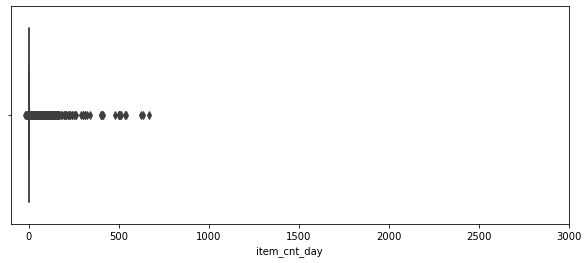

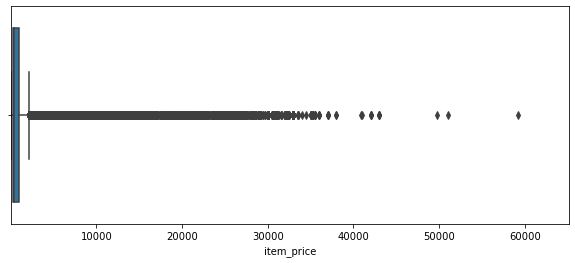

In [12]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [13]:
train.isna().sum().reset_index().to_csv('miss.csv')

Remove the shops with the same names.

In [14]:
id_ = [0, 1, 40]
to_id = [57, 58, 39]
for index, i in enumerate(id_):
    
    train.loc[train.shop_id == i, 'shop_id'] = to_id[index]
    test.loc[test.shop_id == i, 'shop_id'] = to_id[index]


In [15]:
train["date"] = pd.to_datetime(train["date"], format = "%d.%m.%Y")

train["Year"] = train["date"].dt.year

train["Month"] = train["date"].dt.month

monthly_sales = train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().reset_index().rename(columns={"item_cnt_day": "item_cnt_month"}, errors="raise")
monthly_sales['item_cnt_month'] = (monthly_sales['item_cnt_month'].fillna(0).clip(0,20))


index_cols = ['shop_id', 'item_id', 'date_block_num']

df = [] 
cur_shops = []
cur_items = []
block_num = train['date_block_num'].unique()

for num in block_num:
    sh = train.loc[sales['date_block_num'] == num, 'shop_id'].unique()
    it = train.loc[sales['date_block_num'] == num, 'item_id'].unique()
    cur_shops.append(sh)
    cur_items.append(it)

    
for i in range(len(cur_items)):
    df.append(np.array(list(product(*[cur_shops[i], cur_items[i], [block_num[i]]])),dtype='int32'))

df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

df = pd.merge(df, monthly_sales, on=['shop_id', 'item_id', 'date_block_num'], how='left')


test['date_block_num'] = 34
df = pd.concat([df, test], ignore_index=True, sort=False, keys=['shop_id', 'item_id', 'date_block_num'])
df = df.fillna(0)

Feature Engineering

1. Shops features prepossessing
We list the coordinate information of each city, and make a plot to shows the spatial features of the data.

In [16]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [17]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'

coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])

shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]
df = pd.merge(df, shops, on=['shop_id'], how='left')

Text(0, 0.5, 'latitude')

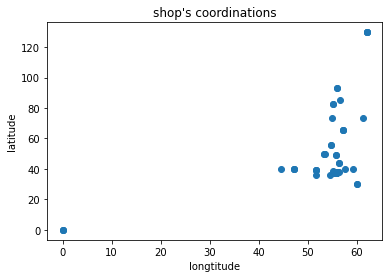

In [18]:
plt.scatter(shops['city_coord_1'], shops['city_coord_2'])
plt.title("shop's coordinations")
plt.xlabel('longtitude')
plt.ylabel('latitude')

2. Items features prepossessing
We divide the items features into large class and small class.

In [19]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [20]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [21]:
to_replace = ['Чистые носители (штучные)', 'Чистые носители (шпиль)', 'PC ', 'Служебные']
replace = ['Чистые носители', 'Чистые носители', 'Аксессуары', 'Служебные ']

replace_map = {}
for i in range(len(to_replace)):
    replace_map[to_replace[i]] = replace[i]

def common(x):
    if x in replace_map.keys():
        return replace_map[x]
    else:
        return x
    
items = pd.merge(items, item_cats, on='item_category_id')
items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])   
items['item_category'] = items['item_category'].apply(lambda x: common(x))
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])
items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]

df = pd.merge(df, items, on=['item_id'], how='left')

3. Interaction Features 

In [22]:
def first_sale(df, col):
    cache = {}
    df[col] = -1
    df[col] = df[col].astype(np.int8)
    for idx, row in df.iterrows():    
        key = str(row.item_id)+' '+str(row.shop_id)
        if key not in cache:
            if row.item_cnt_month!=0:
                cache[key] = row.date_block_num
        else:
            last_date_block_num = cache[key]
            df.at[idx, col] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num    
    return df

df = first_sale(df, 'item_shop_last_sale')
df = first_sale(df, 'item_last_sale')

df['item_shop_first_sale'] = df['date_block_num'] - df.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
df['item_first_sale'] = df['date_block_num'] - df.groupby('item_id')['date_block_num'].transform('min')

4. Targeted Lag Features

In [23]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        tmp.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        tmp['date_block_num'] += i
        df = pd.merge(df, tmp, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

df = lag_feature(df, [1, 2, 3], 'item_cnt_month')

def avg(df, index_cols, target_col):
    group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": target_col}, errors="raise")
    df = pd.merge(df, group, on=index_cols, how='left')
    df[target_col] = df[target_col].fillna(0)
    return df

df = avg(df, ['shop_id', 'item_id', 'date_block_num'], 'avg_shop_price')
df = avg(df, ['item_id', 'date_block_num'], 'avg_item_price')

df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)

df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')
df.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)



<ipython-input-23-05941f2e4d68>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['date_block_num'] += i


5. Target Encoding

In [24]:
def target_encoding(df, col, target_col):
    
    if col == '':
    
        item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": target_col}, errors="raise")
        df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')
    else:
        item_id_target_mean = df.groupby(['date_block_num','item_id', col])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": target_col}, errors="raise")
        df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', col], how='left')

    df[target_col] = df[target_col].fillna(0)

    df = lag_feature(df, [1, 2, 3], target_col)
    df.drop([target_col], axis=1, inplace=True)
    return df

def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df


df = target_encoding(df, '', 'item_target_enc')
df = target_encoding(df, 'city_code', 'item_loc_target_enc')
df = target_encoding(df, 'shop_id', 'item_shop_target_enc')

df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')

<ipython-input-23-05941f2e4d68>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['date_block_num'] += i


6. We should remove the first three months' data for the validation strategy.

In [25]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df.head()

#Save dataset
df.drop(['ID'], axis=1, inplace=True, errors='ignore')
df.to_pickle('df.pkl')

df = pd.read_pickle('df.pkl')
df.info()

X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9933482 entries, 1122795 to 11056276
Data columns (total 32 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   shop_id                     int64  
 1   item_id                     int64  
 2   date_block_num              int64  
 3   item_cnt_month              float64
 4   city_code                   int64  
 5   city_coord_1                float64
 6   city_coord_2                float64
 7   country_part                int64  
 8   item_category_common        int64  
 9   item_category_code          int64  
 10  item_shop_last_sale         int8   
 11  item_last_sale              int8   
 12  item_shop_first_sale        int64  
 13  item_first_sale             int64  
 14  item_cnt_month_lag_1        float16
 15  item_cnt_month_lag_2        float16
 16  item_cnt_month_lag_3        float16
 17  item_shop_price_avg_lag_1   float16
 18  item_shop_price_avg_lag_2   float16
 19  item_shop_pric

Modeling: XGBoost, LightGBM, CatBoost

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
from xgboost import XGBRegressor

feature_name = X_train.columns.tolist()

xgb = XGBRegressor()

feature_name_indexes = [ 'country_part', 'item_category_common', 'item_category_code', 'city_code',]

xgb.fit(X_train[feature_name], Y_train)
xgb_pred = xgb.predict(X_valid[feature_name])

print('mse of xgboost: {}'.format(mean_squared_error(xgb_pred, Y_valid)))
print('mae of xgboost: {}'.format(mean_absolute_error(xgb_pred, Y_valid)))

[23:51:32] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
mse of xgboost: 0.8495707072322977
mae of xgboost: 0.3059507966901955


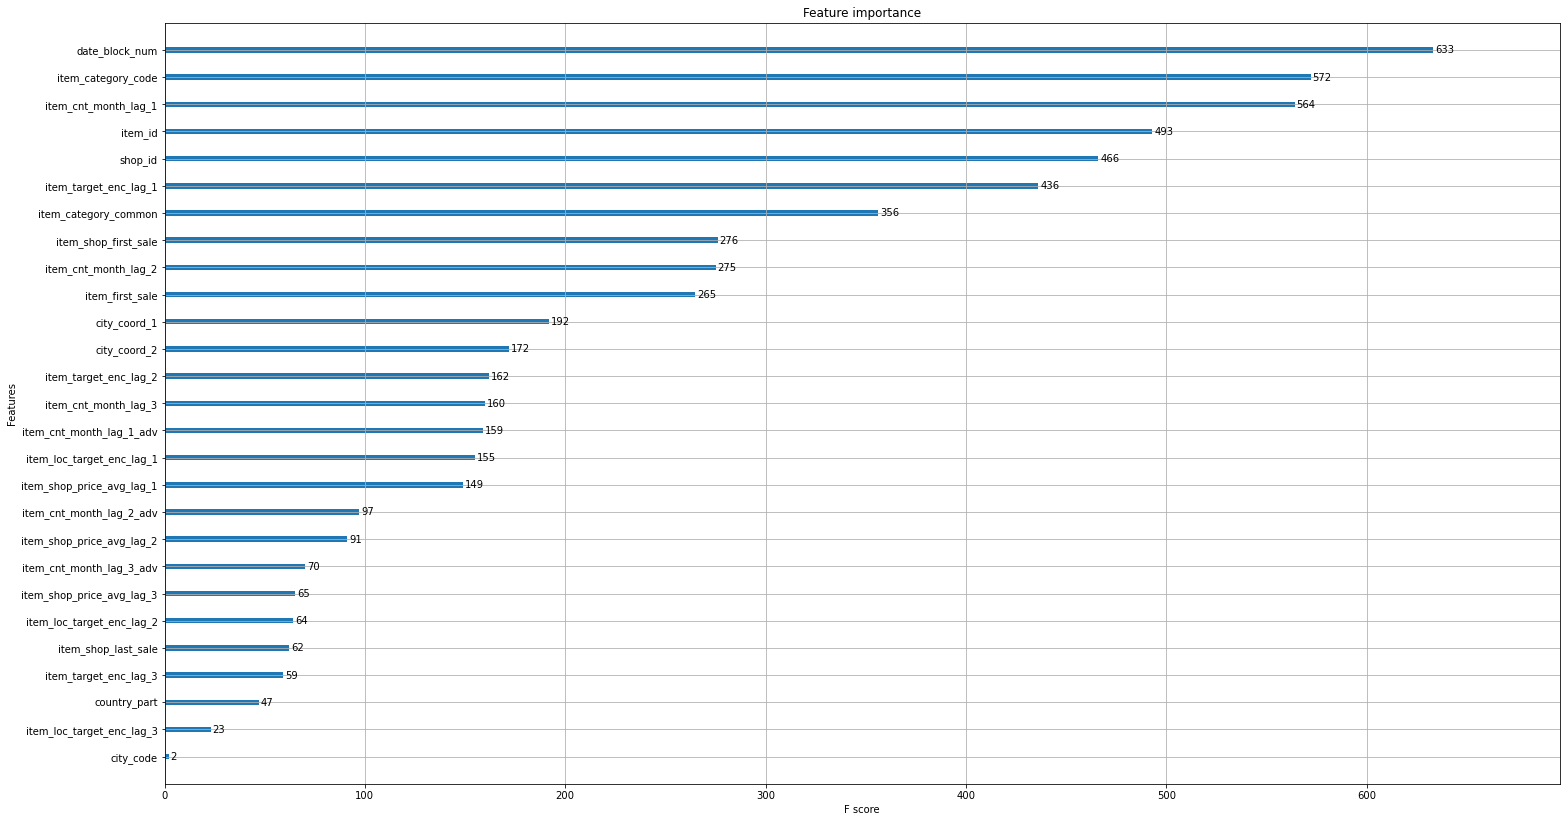

In [28]:
#Plot the feature importance chart
from xgboost import plot_importance
plot_features(xgb, (25,14))
plt.savefig('xgb.png', dpi=300)

In [36]:
from lightgbm import LGBMRegressor

feature_name = X_train.columns.tolist()

lgb = LGBMRegressor()

feature_name_indexes = [ 'country_part', 'item_category_common','item_category_code', 'city_code',]

lgb.fit(X_train[feature_name], Y_train)
lgb_pred = lgb.predict(X_valid[feature_name])

print('mse of lightgbm: {}'.format(mean_squared_error(lgb_pred, Y_valid)))
print('mae of lightgbm: {}'.format(mean_absolute_error(lgb_pred, Y_valid)))

mse of lightgbm: 0.8187787508587724
mae of lightgbm: 0.3047429848359937


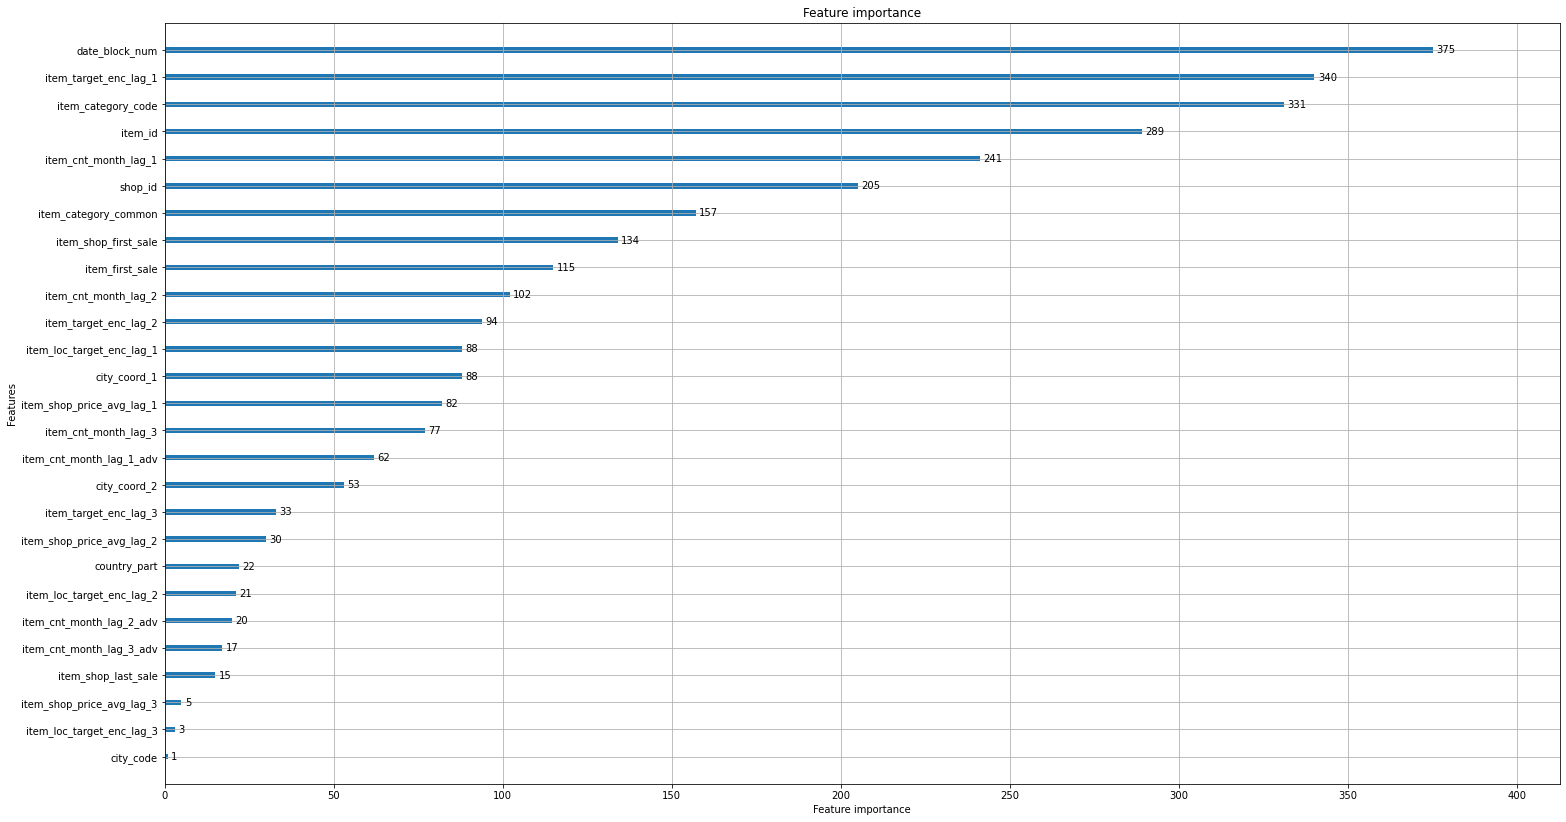

In [30]:
#Plot the feature importance chart
from lightgbm import plot_importance
plot_features(lgb, (25,14))
plt.savefig('lgb.png', dpi=300)

In [31]:
from catboost import CatBoostRegressor

ctb = CatBoostRegressor(
)

ctb.fit(
    X_train, 
    Y_train,)

ctb_pred = ctb.predict(X_valid[feature_name])


Learning rate set to 0.199197
0:	learn: 1.1363633	total: 569ms	remaining: 9m 28s
1:	learn: 1.0796807	total: 932ms	remaining: 7m 45s
2:	learn: 1.0387651	total: 1.36s	remaining: 7m 33s
3:	learn: 1.0100347	total: 1.76s	remaining: 7m 18s
4:	learn: 0.9896206	total: 2.17s	remaining: 7m 12s
5:	learn: 0.9750349	total: 2.58s	remaining: 7m 7s
6:	learn: 0.9648424	total: 3s	remaining: 7m 5s
7:	learn: 0.9573650	total: 3.43s	remaining: 7m 5s
8:	learn: 0.9520569	total: 3.86s	remaining: 7m 5s
9:	learn: 0.9474473	total: 4.29s	remaining: 7m 5s
10:	learn: 0.9428215	total: 4.73s	remaining: 7m 5s
11:	learn: 0.9403173	total: 5.12s	remaining: 7m 1s
12:	learn: 0.9363353	total: 5.54s	remaining: 7m
13:	learn: 0.9333085	total: 6.05s	remaining: 7m 6s
14:	learn: 0.9315400	total: 6.48s	remaining: 7m 5s
15:	learn: 0.9289773	total: 6.91s	remaining: 7m 4s
16:	learn: 0.9278712	total: 7.28s	remaining: 7m
17:	learn: 0.9257490	total: 7.84s	remaining: 7m 7s
18:	learn: 0.9241600	total: 8.35s	remaining: 7m 10s
19:	learn: 0.9

In [37]:
print('mse of catboost: {}'.format(mean_squared_error(ctb_pred, Y_valid)))
print('mae of catboost: {}'.format(mean_absolute_error(ctb_pred, Y_valid)))

mse of catboost: 0.8631184440769858
mae of catboost: 0.30758123976907786


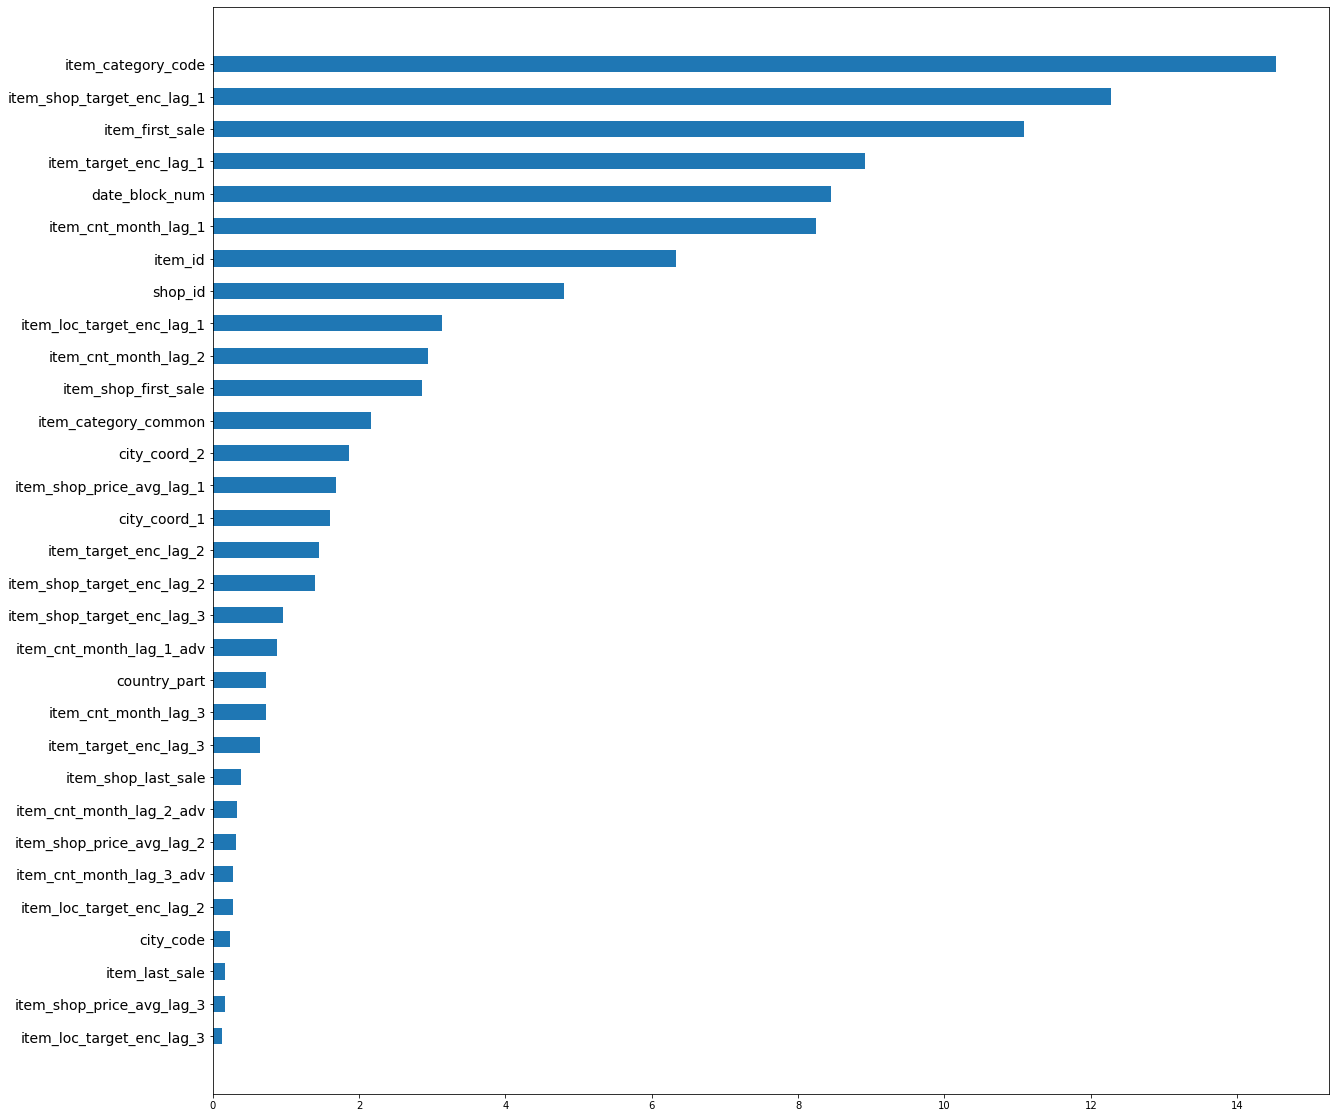

In [33]:
importances = ctb.feature_importances_
names = ctb.feature_names_
data = pd.DataFrame(names, columns=['features'])
data['feature_importance'] = importances
data = data.sort_values(by=['feature_importance'])
figure = plt.figure(figsize=(20,20))
#Plot the feature importance chart
plt.barh(range(len(data)), data.feature_importance.values, height=0.5) 
plt.yticks(range(len(data)),data.features.values, fontsize=14) #data.feature.values is the label
plt.savefig('ctb.png', dpi=300)